## Final Project Submission

Please fill out:
* Student name: Alexander Black
* Student pace: full time
* Scheduled project review date/time: Unscheduled
* Instructor name: Brandon Lewis
* Blog post URL: 


In [226]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk

import spacy 

from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split 

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

In [190]:
from wordcloud import WordCloud
from collections import Counter

import re
import string

In [266]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Input, Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D, Activation
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization
from keras.optimizers import Adam

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

In [220]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from time import time

# Import and preview the data

In [161]:
df = pd.read_csv('df_text_eng.csv')

In [162]:
df.head()

,Unnamed: 0,blurb,state
0,1,"Using their own character, users go on educati...",failed
1,2,"MicroFly is a quadcopter packed with WiFi, 6 s...",successful
2,3,"A small indie press, run as a collective for a...",failed
3,4,Zylor is a new baby cosplayer! Back this kicks...,failed
4,5,Hatoful Boyfriend meet Skeletons! A comedy Dat...,failed


In [163]:
print(df['blurb'].isna().sum())

3


In [164]:
df['blurb'].isna().sum()

3

Checking to see if our labels are evenly balanced....

In [165]:
df['state'].value_counts()

successful    108310
failed        107203
Name: state, dtype: int64

Text(0.5, 1.0, 'Failed vs. Successful Kickstarter Projects')

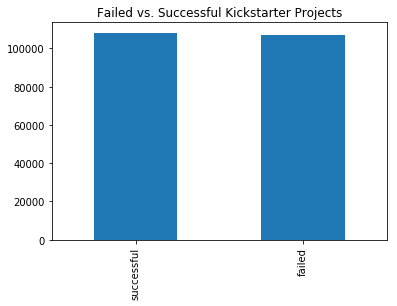

In [173]:
df['state'].value_counts().plot(kind='bar')
plt.title("Failed vs. Successful Kickstarter Projects")

# Preprocessing the Data

In [174]:
df['blurb'].isna().sum()

3

Great! It seems like they are pretty evenly split, this should facilitate model training later on.

In [175]:
# Applying a binary label to the state of the project and putting it in a new column
le = LabelEncoder()
df['failed_or_success'] = le.fit_transform(df['state'])

Below I drop NA values (there were only 3)

In [176]:
print(df['blurb'].isna().sum())


3


In [177]:
df.dropna(inplace=True)

In [179]:
len(df)

215510

Preprocessing and initial clean of the data for EDA purposes

In [180]:
# Cleaning the data to make a wordcloud for both failed and successful projects
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [181]:
#Defining stop words to remove
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [182]:
# First to take 
def clean_text(text):
    #Replaces all punctuation with spaces and lowercases all words
    text = re.sub('[{}]'.format(string.punctuation), ' ', text.lower())
    #Removes stopwords
    return ' '.join([word for word in text.split() if word not in (stop)])

In [183]:

#df['blurb'].apply(lambda t: text.update(clean_text(t).split()))
df['blurb'].describe()

count     215510
unique    214089
top       #NAME?
freq          28
Name: blurb, dtype: object

In [210]:
# Creates new column in df for lowercase text with stopwords removed
df['cleaned_text'] =list(map(lambda t: clean_text(t), df['blurb']))

In [186]:
df.head()

,Unnamed: 0,blurb,state,failed_or_success,cleaned_text
0,1,"Using their own character, users go on educati...",failed,0,using character users go educational quests ar...
1,2,"MicroFly is a quadcopter packed with WiFi, 6 s...",successful,1,microfly quadcopter packed wifi 6 sensors 3 pr...
2,3,"A small indie press, run as a collective for a...",failed,0,small indie press run collective authors want ...
3,4,Zylor is a new baby cosplayer! Back this kicks...,failed,0,zylor new baby cosplayer back kickstarter help...
4,5,Hatoful Boyfriend meet Skeletons! A comedy Dat...,failed,0,hatoful boyfriend meet skeletons comedy dating...


In [129]:
word_counter = {}
textcount = Counter()
word_counter[col] = pd.DataFrame.from_dict(text, orient='index')\
                                    .rename(columns={0: 'count'})\
                                    .sort_values('count', ascending=False)

215510

In [192]:
text = " ".join(blurb for blurb in df['cleaned_text'])

In [205]:
wordcloud = WordCloud(background_color="white", max_words=150, max_font_size=100).generate(text)

Text(0.5, 1.0, 'Wordcloud for ALL Kickstarter Projects')

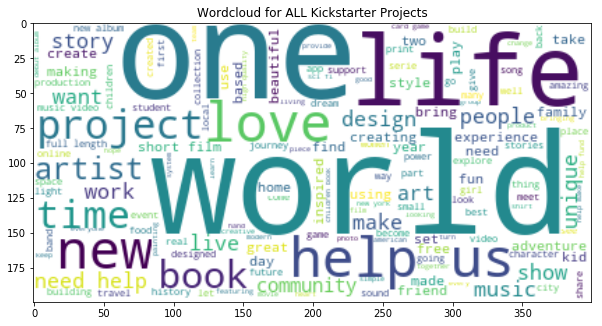

In [206]:
#Trying first wordcloud- this is for ALL projects- successful and non-successful
fig = plt.figure(figsize = (10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Wordcloud for ALL Kickstarter Projects')

In [199]:
text_success = " ".join(blurb for blurb in df.loc[df['failed_or_success'] == 1, 'cleaned_text'])

In [207]:
wordcloud_success = WordCloud(background_color="white", max_words=150, max_font_size=100).generate(text_success)

Text(0.5, 1.0, 'Wordcloud for Successful Kickstarter Projects')

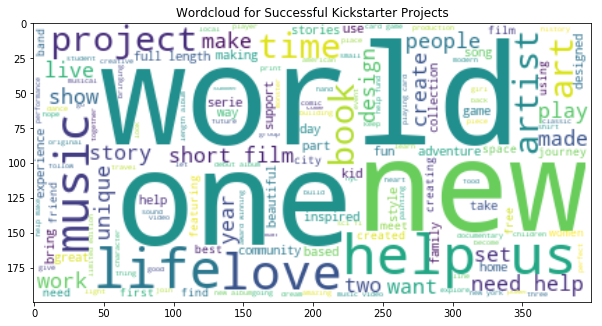

In [208]:
fig = plt.figure(figsize = (10,8))
plt.imshow(wordcloud_success, interpolation='bilinear')
plt.title('Wordcloud for Successful Kickstarter Projects')

In [209]:
text_failure = " ".join(blurb for blurb in df.loc[df['failed_or_success'] == 0, 'cleaned_text'])
wordcloud_failure = WordCloud(background_color="white", max_words=150, max_font_size=100).generate(text_failure)

Text(0.5, 1.0, 'Wordcloud for Failed Kickstarter Projects')

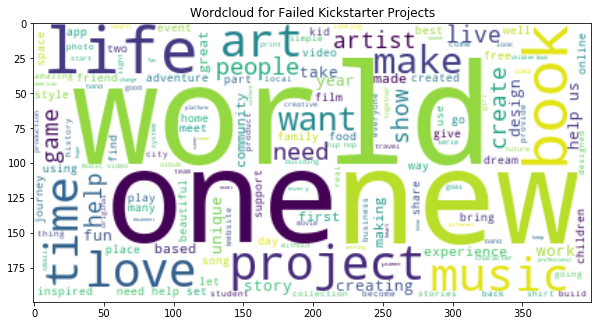

In [211]:
fig = plt.figure(figsize = (10,8))
plt.imshow(wordcloud_failure, interpolation='bilinear')
plt.title('Wordcloud for Failed Kickstarter Projects')

# Word Embedding before modeling

<font color='red'> Add in description of word embedding process

In [213]:
X = df['cleaned_text']
y = df['failed_or_success']

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [215]:
#Tokenizing the data 
tokenizer = Tokenizer(num_words = 20000)
tokenizer.fit_on_texts(list(X_train))

In [216]:
#Turn to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)

In [217]:
#Pad sequences
X_train = sequence.pad_sequences(X_train, maxlen=200)
X_test  = sequence.pad_sequences(X_test,  maxlen=200)

In [219]:
#Check shapes
print('X_train shape:', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape: (183183, 200)
X_test shape:  (32327, 200)


# Trying basic machine learning models before neural nets

In [223]:
entries = []
def train():
    models = {
        "LogisticRegression": LogisticRegression(),
        "SGDClassifier": SGDClassifier(),
        "Multinomial":MultinomialNB(),
        "LinearSVC": LinearSVC(),
    }
    for model in models:
        print("training model"+model)
        start = time()
        models[model].fit(X_train, y_train)
        end = time()
        print("trained in {} secs".format(end-start))
        y_pred = models[model].predict(X_test)
        entries.append((model,accuracy_score(y_test, y_pred)))

In [224]:
train()

training modelLogisticRegression


C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


trained in 24.423986673355103 secs
training modelSGDClassifier


C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


trained in 0.5718061923980713 secs
training modelMultinomial
trained in 0.1679983139038086 secs
training modelLinearSVC


C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


trained in 31.090802669525146 secs


In [225]:
entries

[('LogisticRegression', 0.5252265907755127),
 ('SGDClassifier', 0.49760262319423393),
 ('Multinomial', 0.5096049741701982),
 ('LinearSVC', 0.5015002938719956)]

Not very good accuracy scores using basic models- let's try using a tf_idf vectorizer instead and see if we see improved results

In [227]:
# Resetting train and test since we embedded them using Keras above
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
vectorizer = TfidfVectorizer().fit(X_train)
X_train_tf = vectorizer.transform(X_train)
X_test_tf = vectorizer.transform(X_test)

In [228]:
entries_tfidf = []
def train2():
    models = {
        "LogisticRegression": LogisticRegression(),
        "SGDClassifier": SGDClassifier(),
        "Multinomial":MultinomialNB(),
        "LinearSVC": LinearSVC(),
    }
    for model in models:
        print("training model"+model)
        start = time()
        models[model].fit(X_train_tf, y_train)
        end = time()
        print("trained in {} secs".format(end-start))
        y_pred = models[model].predict(X_test_tf)
        entries_tfidf.append((model,accuracy_score(y_test, y_pred)))

In [229]:
train2()

training modelLogisticRegression


C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


trained in 1.6689975261688232 secs
training modelSGDClassifier


C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


trained in 0.17299771308898926 secs
training modelMultinomial
trained in 0.03800010681152344 secs
training modelLinearSVC
trained in 2.4980015754699707 secs


In [230]:
entries_tfidf

[('LogisticRegression', 0.5252265907755127),
 ('SGDClassifier', 0.49760262319423393),
 ('Multinomial', 0.5096049741701982),
 ('LinearSVC', 0.5015002938719956),
 ('LogisticRegression', 0.6765861354285891),
 ('SGDClassifier', 0.6693476041698889),
 ('Multinomial', 0.6723172580196121),
 ('LinearSVC', 0.6634082964704426)]

# Interesting, our model seems to have been much more successful using TFIDF instead of word embeddings. 

# Attempting Neural Networks

In [231]:
# number of unique words we want to use (or: number of rows in incoming embedding vector)
max_features = 20000 

# max number of words in a comment to use (or: number of columns in incoming embedding vector)
max_len = 200 

# dimension of the embedding variable (or: number of rows in output of embedding vector)
embedding_dims = 128

In [261]:
# First to set up the model
base_model = Sequential()

# add embedding layer 
base_model.add(Embedding(input_dim=max_features, input_length=max_len,
                         output_dim=embedding_dims))

# add pooling layer 
# ... which will extract features from the embeddings of all words in the comment
base_model.add(GlobalMaxPool1D())

# add dense layer to produce an output dimension of 50 and apply relu activation
base_model.add(Dense(50, activation='relu'))

# set the regularizing dropout layer to drop out 30% of the nodes
base_model.add(Dropout(0.3))

# finally add a dense layer
# ... which projects output into six units and squash it with sigmoid activation
base_model.add(Dense(1, activation='sigmoid'))

# RESETTING X AND Y TRAIN BELOW

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [256]:
#Tokenizing the data 
tokenizer = Tokenizer(num_words = 20000)
tokenizer.fit_on_texts(list(X_train))

In [257]:
#Turn to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)

In [258]:
#Pad sequences
X_train = sequence.pad_sequences(X_train, maxlen=200)
X_test  = sequence.pad_sequences(X_test,  maxlen=200)

# Compiling the model

In [267]:
checkpoints_path = 'weights_base.best.hdf5'
checkpoint = ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [268]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=25)

In [273]:
callbacks = [checkpoint, early_stopping]

In [274]:
base_model.compile(loss='binary_crossentropy',
                   optimizer=Adam(0.01), metrics=['accuracy'])

# check the model with all our layers
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                6450      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 2,566,501
Trainable params: 2,566,501
Non-trainable params: 0
_________________________________________________________________


# Fitting the model

In [281]:
base_hist = base_model.fit(X_train, y_train, batch_size=32, 
                           epochs=3, validation_split=0.1, callbacks=callbacks, verbose=2)

Train on 164864 samples, validate on 18319 samples
Epoch 1/3
 - 132s - loss: 0.4690 - acc: 0.7510 - val_loss: 0.6731 - val_acc: 0.6479

Epoch 00001: val_loss did not improve from 0.60522
Epoch 2/3
 - 133s - loss: 0.4297 - acc: 0.7684 - val_loss: 0.7429 - val_acc: 0.6582

Epoch 00002: val_loss did not improve from 0.60522
Epoch 3/3
 - 131s - loss: 0.3970 - acc: 0.7817 - val_loss: 0.8927 - val_acc: 0.6446

Epoch 00003: val_loss did not improve from 0.60522


In [264]:

# evaluate the algorithm on the test dataset
#base_test_loss, base_test_auc = base_model.evaluate(X_test, y_test, batch_size=32)
print('Test Loss:    ', base_test_loss)
print('Test Accuracy:', base_test_auc)

Test Loss:     0.6330191248029716
Test Accuracy: 0.6653880657091228


Not terrible results, but we have a pretty high test loss, maybe we can change our model to reduce test loss somehow. 

# Attempting a CNN model without LSTM

In [282]:
# instantiate CNN model
cnn_model = Sequential()

# add embedding layer 
cnn_model.add(Embedding(input_dim=max_features, input_length=max_len,
                        output_dim=embedding_dims))
 
# set the dropout layer to drop out 50% of the nodes
cnn_model.add(SpatialDropout1D(0.5))

# add convolutional layer that has ...
# ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
cnn_model.add(Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'))

# add normalization layer
cnn_model.add(BatchNormalization())

# add pooling layer 
cnn_model.add(GlobalMaxPool1D())

# set the dropout layer to drop out 50% of the nodes
cnn_model.add(Dropout(0.5))

# add dense layer to produce an output dimension of 50 and using relu activation
cnn_model.add(Dense(50, activation='relu'))

# finally add a dense layer
cnn_model.add(Dense(1, activation='sigmoid'))

In [283]:
cnn_model.compile(loss='binary_crossentropy',
                  optimizer=Adam(0.01),
                  metrics=['accuracy'])

cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 100)          51300     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 100)          400       
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 100)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                5050      
__________

In [284]:
cnn_hist = cnn_model.fit(X_train, y_train, batch_size=32, 
                         epochs=3, validation_split=0.1, callbacks=callbacks, verbose=2)

Train on 164864 samples, validate on 18319 samples
Epoch 1/3
 - 243s - loss: 0.6956 - acc: 0.5023 - val_loss: 0.6932 - val_acc: 0.5059

Epoch 00001: val_loss did not improve from 0.60522
Epoch 2/3
 - 240s - loss: 0.6935 - acc: 0.5010 - val_loss: 0.6932 - val_acc: 0.4941

Epoch 00002: val_loss did not improve from 0.60522
Epoch 3/3
 - 238s - loss: 0.6934 - acc: 0.5014 - val_loss: 0.6935 - val_acc: 0.5059

Epoch 00003: val_loss did not improve from 0.60522


In [ ]:
cnn_test_loss, cnn_test_auc = cnn_model.evaluate(X_test, y_test, batch_size=32)
print('Test Loss:    ', cnn_test_loss)
print('Test Accuracy:', cnn_test_auc)

# Still not great results- and worse performing than our basic neural network model.

Here, bring in other kickstarter data and run a model off of not just blurb. Perhaps the blurb really just isn't a big determinant of whether or not a project will be successful. I think there are a lot more factors (goal size, timing of project, country of launch, area of interest) that determine whether or not a kickstarter project will reach its fundraising goal.
